# Quickstart notebook

We've taken 'postage stamps' of 25 x 25 km areas of Australia, and extracted geology, geophysics and aster coverages for these areas. Some of the areas have one or more mineral deposits (up to 42 deposits in one case near Kalgoorlie, Western Australia), while some do not. 

Each dataset has layers organized under a data ID - an 8 digit identifier:

```
$stamp_id/
    proj4_projection_definition.txt   # only in training data - has local Mercator projection info as Proj4 string
    commodities.csv                   # only in training data - known deposit locations. Might be empty (for areas with no _known_ deposits)
    geology/                          # surface geology from GA: https://data.gov.au/dataset/ds-dga-48fe9c9d-2f10-49d2-bd24-ac546662c4ec/details
    geophysics/
        gravity/                      # from GA's regional gravity compilation
        magnetics/                    # from http://www.ga.gov.au/news-events/news/latest-news/latest-editions-of-magnetic-anomaly-grid-and-radiometric-map-released
        radiometrics/
    remote_sensing/
        aster/                        # ASTER data 
```

The stamps have all been regridded and reprojected to a local oblique mercator grid, so that the x and y coordinates are in metres from the centre of the grid. You can certainly undo this pretty easily with a bit of image matching or database lookup but it's really not worth it because we're not using the scoreboard as part of the judging - more as benchmarking and feedback for your models. You'll need to convince us that you haven't overfit to the leaderboard as part of your submission! The stamps have been generated using the code in the Unearthed [explore_australia repository](https://github.com/unearthed/explore_australia).

### Notebook requirements

We'll use [pandas](http://pandas.pydata.org), [geopandas](http://geopandas.org) (a spatial extension for pandas which uses [shapely](https://shapely.readthedocs.io/en/latest/) and [fiona](https://fiona.readthedocs.io/en/latest/) under the hood) and [rasterio](https://rasterio.readthedocs.io/en/stable/). We also need [matplotlib](https://matplotlib.org) for plotting.

Install with `{conda|pip} install pandas geopandas shapely fiona rasterio matplotlib descartes`. If you're already using the Unearthed [explore_australia repository](https://github.com/unearthed/explore_australia) then the environment.yml file in that repo also works.

### Predictions and benchmarking submissions

We're providing both training (1863 stamps) and testing datasets (622), stratified roughly by commodity type. Test datasets have the projection string and commodities csvs removed but the other layers remain the same.

We can have a look at one of the training stamps as an example

In [1]:
from pathlib import Path
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd

In [2]:
# Load up deposits for a given area
folder = Path('./train/train/70193655')
deposits = pd.read_csv(folder / 'commodities.csv')
deposits['geometry'] = list(zip(deposits.x, deposits.y))
deposits['geometry'] = deposits['geometry'].apply(Point)
deposits = gpd.GeoDataFrame(deposits)

In [3]:
deposits

,stamp_id,x,y,commodity,geometry
0,70193655,32.371423,-1075.753128,Au,POINT (32.371 -1075.753)
1,70193655,580.079992,-517.124313,Au,POINT (580.080 -517.124)
2,70193655,-1367.506758,-1535.227636,Au,POINT (-1367.507 -1535.228)
3,70193655,122.366343,-419.357202,Au,POINT (122.366 -419.357)
4,70193655,-1838.065779,-1429.055829,Au,POINT (-1838.066 -1429.056)
5,70193655,-1845.526075,2824.938275,Au;Sb,POINT (-1845.526 2824.938)
6,70193655,3115.377224,-2177.295119,Au,POINT (3115.377 -2177.295)


Looks like a gold mining area - note that these are probably a combination of sediment-hosted (straight Au) and basement/vein hosted deposits (at least the one with antimony is likely to be)

For predictions we're looking for a list of these with multiple lines per stamp if you think there are multiple deposits. For example if I thought there was three gold deposits in this stamp then I'd have the following lines in my submission

In [4]:
predicted_deposits = pd.DataFrame(
    [
        ('70193655', -1500, 50, 'Au'),
        ('70193655', 0, 0, 'Au;W'),
        ('70193655', 500, -1500, 'Au;Cu;U')
    ], columns=('stamp_id', 'x', 'y', 'commodity')
)

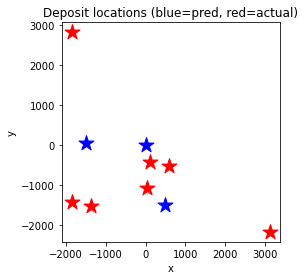

In [5]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)
deposits.plot(marker='*', facecolor='red', edgecolor='red', markersize=250, ax=ax)
predicted_deposits.plot('x', 'y', kind='scatter', marker='*', color='blue', s=250, ax=ax)
ax.set_title('Deposit locations (blue=pred, red=actual)')
f.tight_layout()

Concatenate all your predictions into a single frame and you can just dump to csv with `predicted_deposits.to_csv('predictions.csv', index=False, sep=',', encoding='utf-8')`.

Scoring is a little bit tricky since we can have multiple commodities and multiple locations in a given stamp. To score this we're using a combination metric which places 75% value on whether you get the commodity correct (probably the easiest bit to predict), and 25% on the location (which are going to be much harder to predict). So 

$$
S = \mathrm{mean}(0.25 S_\text{location} + 0.75 S_\text{commodity label})
$$

where the mean is taken over all the stamps in the test set

**Comodity label scoring**

We score the commodity predictions by merging all the commodities into a single commodity string. We assign a value of +1 for a correct commodity, -1 for an incorrect commodity, and -0.5 for a missed commodity. We then squash this into a (0,1) error based on the number of commodities in the stamp (essentially the score if you got them all right vs the score if you got them all wrong):

$$
S_\text{commodity label} = 1 / 2 + \frac{N_\mathrm{correct} - 0.5 N_\mathrm{missed} - N_\mathrm{incorrect}}{2 (N_\mathrm{correct} + N_\mathrm{missed} + N_\mathrm{incorrect})}
$$

where $N_\mathrm{correct}$, $N_\mathrm{missed}$ and $N_\mathrm{incorrect}$ are the correct, missed and incorrect commodity labels respectively. So you'll get 1 if you get all the labels correct, 0.25 if you miss everything, and 0 if you get them all wrong. For the special case of no commodities in the stamp, we'll score 1 if you also provide no commodities, otherwise we'll provide 0 (since all commoditied are wrong).

**Location**

For the location we just use the mean minimum distance to an actual deposit, scaled by the length of the diagonal of the stamp (which is the largest distance possible) to get a value between 0 and 1.

$$
S_\text{location} = \sum_{i}^{M} 1 - \frac{\mathrm{min}_{j}(|x_\text{pred, i} - x_\text{actual,j}|)}{D M}
$$

where $D = \sqrt{25\text{ km}^2 + 25\text{ km}^2} \approx 35.355339\text{ km}$ is the length of the diagonal of the stamp, $x_\text{pred, i}$ is a list of predicted deposit locations, $M$ the number of predicted deposits, and $x_\text{actual, j}$ is the list of actual deposit locations. Again, if there's no deposit and you provide deposits for the stamp, we'll score 1, or 0 if you don't provide any. So you're better off predicting fewer deposits and getting the location right if you can. For all the submissions you could start with a list of stamps that you thought contained a particular commodity, with (0, 0) for the deposit location.

These metrics certainly aren't the best for every model and every prediction, so when you're preparing your submission feel free to tell us why you chose something different for the model of your choice. These metrics will penalise false positives pretty heavily so you're best off getting presence-absence going first and then going for location accuracy.

We've included an implementation of these metrics for you to use if you'd like when training

In [6]:
def accumulate_commodity_labels(df):
    "Accumulate commodity labels from a dataframe with a 'commodity' column"
    commodities = set()
    for comm in df.commodity:
        for comm in comm.split(';'):
            commodities.add(comm)
    return commodities

def score_commodity_label(predicted, actual):
    """
    Score the predictions for commodity label against the actual values
    
    Parameters:
        predicted, actual - predicted and actual deposit info
    """
    # Handle zero deposit case
    if len(actual) == 0:
        if len(predicted) == 0:
            return 1.0
        else:
            return 0.0
    elif len(predicted) == 0:
        return 0.0

    # Accumulate all commodity types
    pred_commodities = accumulate_commodity_labels(predicted)
    actual_commodities = accumulate_commodity_labels(actual)
    
    # Work out how many right, missed and wrong
    right = len([c for c in pred_commodities if c in actual_commodities])
    wrong = len([c for c in pred_commodities if c not in actual_commodities])
    missed = len([c for c in actual_commodities if c not in pred_commodities])
    total = right + wrong + missed
    return 0.5 + ((right - 0.5 * missed - wrong) / (2 * total))

To test this on our predictions

In [7]:
accumulate_commodity_labels(deposits)

{'Au', 'Sb'}

In [8]:
accumulate_commodity_labels(predicted_deposits)

{'Au', 'Cu', 'U', 'W'}

We've got one right (Au), three wrong (Cu, U, W) and one missed (Sb)

In [9]:
score_commodity_label(predicted=predicted_deposits, actual=deposits)

0.25

Next we do distance - we've not done too badly on this metric since our predictions are close to the actual locations

In [10]:
from math import sqrt

MAX_DISTANCE = sqrt(25000 ** 2 + 25000 ** 2)

def score_deposit_distance(predicted, actual):
    """
    Score the predictions for deposit distance against actual values
    
    Parameters:
        predicted, actual - predicted and actual deposit info
    """
    # Handle zero deposit case
    if len(actual) == 0:
        if len(predicted) == 0:
            return 1.0
        else:
            return 0.0
    elif len(predicted) == 0:
        return 0.0

    # Pull locations from dataframes
    get_location = lambda df: list(zip(df.x, df.y))
    predicted_location = get_location(predicted)
    actual_location = get_location(actual)

    # Assume euclidean distances
    distance = lambda p1, p2: sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)
    
    # Calcualte mean minimum distance
    mean_min_dist = sum([
        min([distance(p, a) for a in actual_location])
        for p in predicted_location
    ]) / (MAX_DISTANCE * len(predicted_location))

    # Score is 1 - mean minimum
    return 1 - mean_min_dist

In [11]:
score_deposit_distance(predicted=predicted_deposits, actual=deposits)

0.9756242202824272

Then our total score is just 

In [12]:
def score_stamp(predicted, actual):
    """
    Score the stamp for a given 
    
    Parameters:
        predicted, actual - predicted and actual deposit info
    """
    # Accumulate commodity labels
    comm_score = score_commodity_label(predicted=predicted, actual=actual)
    
    # Distance to deposit
    dist_score = score_deposit_distance(predicted=predicted, actual=actual)
    
    return 0.75 * comm_score + 0.25 * dist_score

In [13]:
score_stamp(predicted=predicted_deposits, actual=deposits)

0.4314060550706068

and to check the empty cases

In [14]:
zero_deposits = pd.DataFrame([], columns=deposits.columns)

In [15]:
zero_deposits.shape[0]

0

In [16]:
score_stamp(zero_deposits, deposits)

0.0

In [17]:
score_stamp(predicted_deposits, zero_deposits)

0.0

In [18]:
score_stamp(zero_deposits, zero_deposits)

1.0

### Reading datasets

This is basically a quickstart on reading these datasets in Python. 

In the root directory in the training datasets there are a list of deposits (if any) and a text file with the local projection, should you want to reproject back to some other frame. You won't have the local projection in the test dataset so don't rely on this. 

In [19]:
list(folder.iterdir())

[WindowsPath('train/train/70193655/commodities.csv'),
 WindowsPath('train/train/70193655/geology'),
 WindowsPath('train/train/70193655/geophysics'),
 WindowsPath('train/train/70193655/proj4_projection_definition.txt'),
 WindowsPath('train/train/70193655/remote_sensing')]

We've already loaded up the deposit locations with shapely, pandas and geopandas

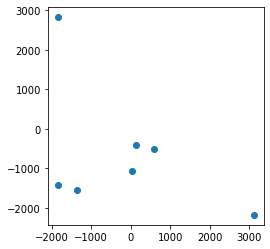

In [20]:
deposits.plot()

In the geology folder is a list of geology layers

In [21]:
lines = gpd.read_file(folder / 'geology' / 'misc_lines.geo.json')
units = gpd.read_file(folder / 'geology' / 'geological_unit_polygons.geo.json')
contacts = gpd.read_file(folder / 'geology' / 'unit_contacts.geo.json')
faults = gpd.read_file(folder / 'geology' / 'shears_and_faults.geo.json')

In [22]:
contacts

,id,TYPENAME,TYPE_URI,CNTCTNAME,DESCR,EXPOSURE,OBSMETHOD,CONFIDENCE,POSACC_M,SOURCE,...,RESSCALE,CAPTSCALE,CAPTDATE,MODDATE,PLOTRANK,FEATCODE,FEATUREID,CONTACTID,SHAPE_LEN,geometry
0,495991,lithogenetic contact,http://resource.geosciml.org/classifier/cgi/co...,None,geological boundary,exposed,synthesis of multiple published descriptions,None,500,"Bultitude RJ, Garrad PD & Roberts CW (compiler...",...,1000000,500000,2005-09-19,2012-09-17,1,1000100,GA_GC1M_0506791,GA.Contact.SurfaceGeology1M.GA_GC1M_0506791,0.116393,"MULTILINESTRING ((-12003.894 -12491.239, -1202..."
1,496109,lithogenetic contact,http://resource.geosciml.org/classifier/cgi/co...,None,geological boundary,exposed,synthesis of multiple published descriptions,None,500,"Bultitude RJ, Garrad PD & Roberts CW (compiler...",...,1000000,500000,2005-09-19,2012-09-17,1,1000100,GA_GC1M_0506906,GA.Contact.SurfaceGeology1M.GA_GC1M_0506906,0.030428,"LINESTRING (-11476.293 -4604.667, -11494.557 -..."
2,496294,lithogenetic contact,http://resource.geosciml.org/classifier/cgi/co...,None,geological boundary,exposed,synthesis of multiple published descriptions,None,500,"Bultitude RJ, Garrad PD & Roberts CW (compiler...",...,1000000,500000,2005-09-19,2012-09-17,1,1000100,GA_GC1M_0507102,GA.Contact.SurfaceGeology1M.GA_GC1M_0507102,0.017557,"LINESTRING (-10717.074 -3843.424, -10688.328 -..."
3,496541,lithogenetic contact,http://resource.geosciml.org/classifier/cgi/co...,None,geological boundary,exposed,synthesis of multiple published descriptions,None,500,"Bultitude RJ, Garrad PD & Roberts CW (compiler...",...,1000000,500000,2005-09-19,2012-09-17,1,1000100,GA_GC1M_0507353,GA.Contact.SurfaceGeology1M.GA_GC1M_0507353,0.101447,"LINESTRING (-8911.822 -3748.912, -8960.033 -37..."
4,496542,lithogenetic contact,http://resource.geosciml.org/classifier/cgi/co...,None,geological boundary,exposed,synthesis of multiple published descriptions,None,500,"Bultitude RJ, Garrad PD & Roberts CW (compiler...",...,1000000,500000,2005-09-19,2012-09-17,1,1000100,GA_GC1M_0507354,GA.Contact.SurfaceGeology1M.GA_GC1M_0507354,0.000329,"LINESTRING (-8917.960 -3783.514, -8911.822 -37..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,499873,lithogenetic contact,http://resource.geosciml.org/classifier/cgi/co...,None,geological boundary,exposed,synthesis of multiple published descriptions,None,500,"Bultitude RJ, Garrad PD & Roberts CW (compiler...",...,1000000,500000,2005-09-19,2012-09-17,1,1000100,GA_GC1M_0510783,GA.Contact.SurfaceGeology1M.GA_GC1M_0510783,0.094117,"MULTILINESTRING ((12443.333 -12017.598, 12402...."
64,499973,lithogenetic contact,http://resource.geosciml.org/classifier/cgi/co...,None,geological boundary,exposed,synthesis of multiple published descriptions,None,500,"Bultitude RJ, Garrad PD & Roberts CW (compiler...",...,1000000,500000,2005-09-19,2012-09-17,1,1000100,GA_GC1M_0510893,GA.Contact.SurfaceGeology1M.GA_GC1M_0510893,0.110444,"MULTILINESTRING ((12442.946 -11315.679, 12437...."
65,500320,lithogenetic contact,http://resource.geosciml.org/classifier/cgi/co...,None,geological boundary,exposed,synthesis of multiple published descriptions,None,500,"Bultitude RJ, Garrad PD & Roberts CW (compiler...",...,1000000,500000,2005-09-19,2012-09-17,1,1000100,GA_GC1M_0511252,GA.Contact.SurfaceGeology1M.GA_GC1M_0511252,0.120245,"LINESTRING (12441.669 -9250.882, 12411.812 -92..."
66,500405,lithogenetic contact,http://resource.geosciml.org/classifier/cgi/co...,None,geological boundary,exposed,synthesis of multiple published descriptions,None,500,"Bultitude RJ, Garrad PD & Roberts CW (compiler...",...,1000000,500000,2005-09-19,2012-09-17,1,1000100,GA_GC1M_0511342,GA.Contact.SurfaceGeology1M.GA_GC1M_0511342,0.231311,"LINESTRING (12427.969 4422.955, 12415.165 4415..."


> **A quick side note on GeoJSON and coordinate reference systems** - GeoJSON doesn't provide for CRS information but assumes that everything is in Web Mercator/EPSG:4326 (see [the GeoJSON spec](https://tools.ietf.org/html/rfc7946#section-4]) for more details). When you read a GeoJSON file with GeoPandas it automatically assigns a CRS of EPSG:4326 to your dataframe - this will be wrong, so don't try using any of GeoPandas' reprojection methods or you're going to get weird results.

We can generate a rough geological map of the area using these layers

In [23]:
units.PLOTSYMBOL.unique()

array(['Czs', 'Qa', 'Ds', 'Pg', 'Czl', 'Dh', 'Cza'], dtype=object)

In [24]:
# colors based on plotsymbol - if interested in Australia's geological mapping colors see https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/21883
colors = {
    'Q': (.70, 1.00, .64),
    'Qa': (1.00, 1.00, .19),
    'Cza': (.80, .80, .24),
    'Czs': (.92, .84, .19),
    'Czl': (1.00, .95, .19),
    'Dh': (1.00, .66, .19),
    'Ds': (1.00, .51, .19),
    'Pg': (.36, .100, .19),
}
facecolors = [colors[p] for p in units.PLOTSYMBOL]

Now we can plot the geology with the colors given above, the faults in red and the deposit locations with stars (you might get some warnings about empty GeoDataFrames if you've not got a particular geometry represented in this stamp).

There's something weird going on with a mismatch between colors/labels here but can't be arsed debugging.

D:\Anaconda3\envs\geosciences\lib\site-packages\geopandas\plotting.py:529: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


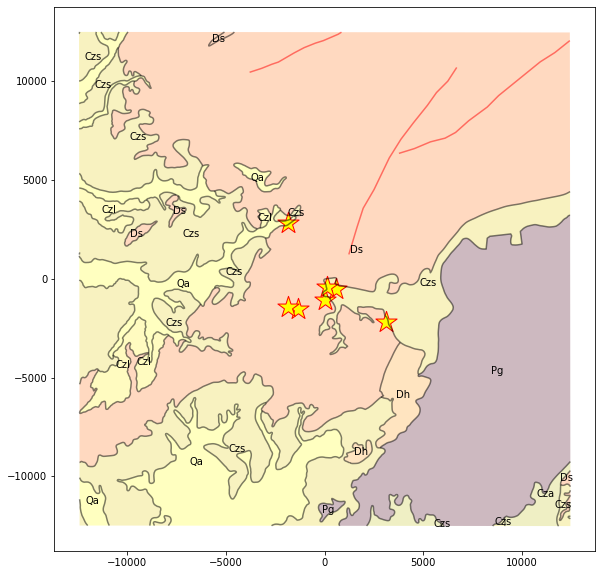

In [25]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)
f.set_size_inches(10, 10)
contacts = gpd.read_file(folder / 'geology' / 'unit_contacts.geo.json')
units.plot(edgecolor='none', facecolor=facecolors, alpha=0.3, ax=ax)
for loc, symb in zip(units.representative_point(), units.PLOTSYMBOL):
    ax.text(loc.x, loc.y, symb, horizontalalignment='center', verticalalignment='center')
contacts.plot(edgecolor='black', alpha=0.5, ax=ax)
faults.plot(edgecolor='red', alpha=0.5, ax=ax)
lines.plot(edgecolor='blue', alpha=0.5, ax=ax)
deposits.plot(marker='*', facecolor='yellow', edgecolor='red', markersize=500, ax=ax)

In the geophysics folder there are aligned coverages from the continent-wide magnetics, gravity and radiometrics surveys

In [26]:
import rasterio

tiffs = lambda folder: [f for f in folder.iterdir() if str(f).endswith('tif')]
tiff_to_imshow = lambda t: t.transpose()[:, ::-1]  # imshow uses a different convention for top-right-bottom-left

def plot_tiffs(tiffs):
    n_tiffs = len(tiffs)
    f, axes = plt.subplots(1, n_tiffs)
    f.set_size_inches(n_tiffs * 4, 4)
    for tiff, ax in zip(tiffs, axes):
        with rasterio.open(tiff, 'r') as src:
            ax.imshow(tiff_to_imshow(src.read(1)))
            ax.set_title(tiff.stem.replace('_', ' '))
    f.tight_layout()

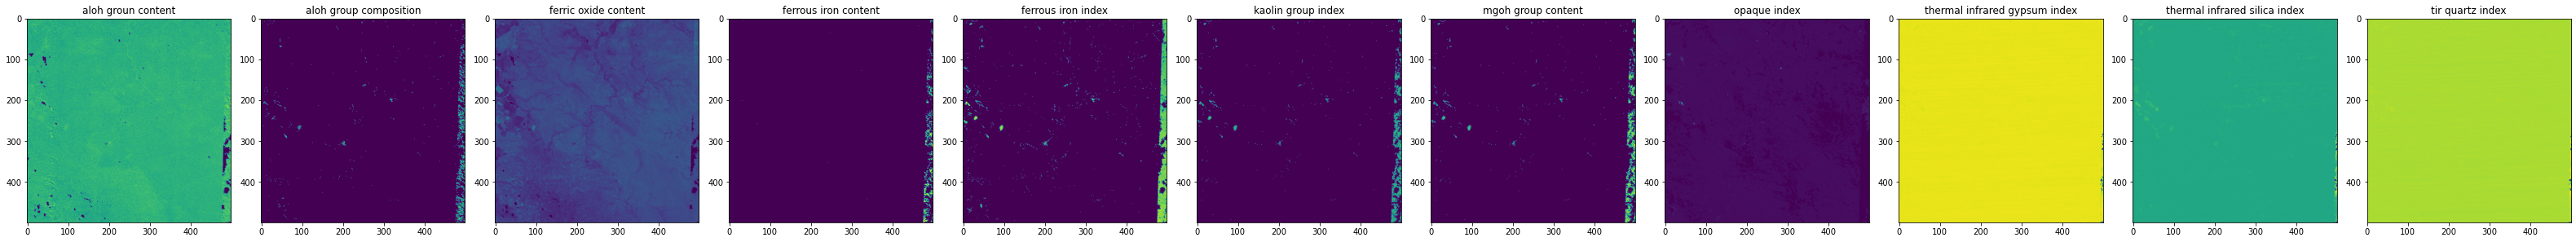

In [27]:
plot_tiffs(tiffs(folder / 'remote_sensing' / 'aster'))

Note that some of these channels are group values (so categorical) and some are continuous (e.g. the Ferric Oxide content).

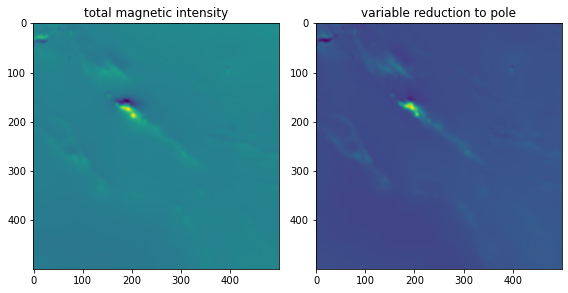

In [28]:
plot_tiffs(tiffs(folder / 'geophysics' / 'magnetics'))

NOte that the TMI and VRTP are quite similar but there are subtle differences in the shape of the anomalies - in general VRTP will give a more accurate representation since the VRTP process adjusts the magnetic anomalies so that simple features are mapped directly over the magnetic bodies (see [here](http://www.ga.gov.au/news-events/news/latest-news/latest-editions-of-magnetic-anomaly-grid-and-radiometric-map-released) for more details).

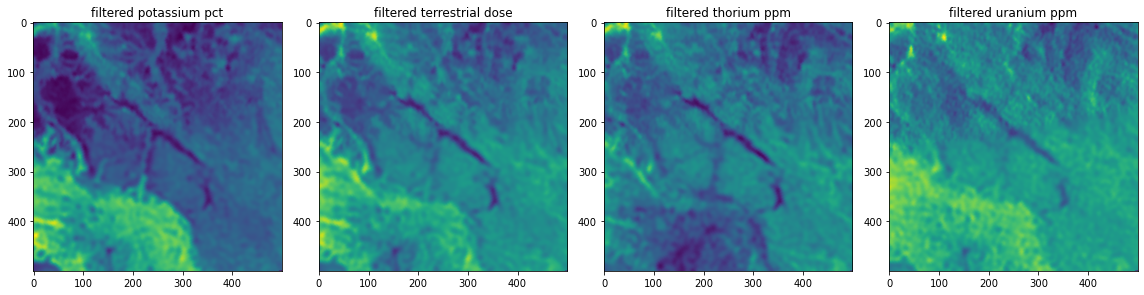

In [29]:
plot_tiffs(tiffs(folder / 'geophysics' / 'radiometrics'))

There's a granite or something sticking out like a sore thumb in the lower left corner

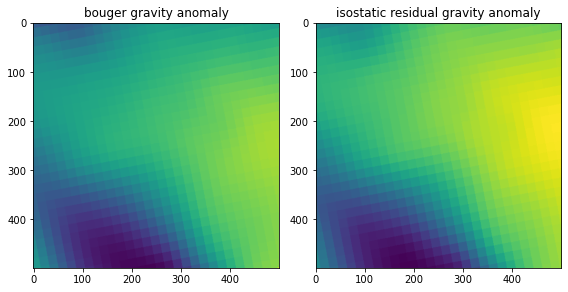

In [30]:
plot_tiffs(tiffs(folder / 'geophysics' / 'gravity'))

Again you can see the lower density granite in the bottom left. There's not as much useful high-resolution info in the gravitiy but it is useful for identifiying areas where differing rocks are in contact, or where different crustal blocks can provide channels for mineralizing fluids so it's often a good place to start.

In [31]:
tiff = tiffs(folder / 'remote_sensing' / 'aster')[0]
with rasterio.open(tiff, 'r') as src:
    print(src.read(1).shape)
    print(src.read(1))

(500, 500)
[[1.9014561 1.8831214 1.8667104 ... 2.0469315 0.        0.       ]
 [1.984713  1.9210972 1.8997555 ... 2.012836  0.        0.       ]
 [1.9324478 1.8514245 1.7870075 ... 2.027559  0.        0.       ]
 ...
 [0.        1.737069  1.737069  ... 1.7480127 1.9494681 1.8818818]
 [0.        0.        1.7467145 ... 1.9209225 1.8867562 1.877451 ]
 [0.        0.        1.7195358 ... 1.6894009 1.7925532 0.       ]]
